In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Importando Bibliotecas**

In [ ]:
import re
import subprocess
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#**Preparando os dados**

In [ ]:

#Script para extrair notas e textos de reviews


def ler_docx(caminho_arquivo):

    try:
        resultado = subprocess.run(
            ['pandoc', caminho_arquivo, '-t', 'plain'],
            capture_output=True,
            text=True,
            check=True
        )
        return resultado.stdout
    except subprocess.CalledProcessError as e:
        print(f"Erro ao ler o arquivo: {e}")
        sys.exit(1)

def extrair_reviews(texto):
    """
    Extrai todas as reviews do texto usando regex
    Retorna uma lista de tuplas (texto_review, nota)
    """
    # Pattern para capturar
    pattern = r'(\d+)\s*/10\s*(.*?)\s*Helpful'

    # re.DOTALL faz o . capturar também quebras de linha
    matches = re.findall(pattern, texto, re.DOTALL)

    reviews = []
    for match in matches:
        nota = int(match[0])
        texto_review = match[1].strip()
        # Limpa espaços extras e quebras de linha múltiplas
        texto_review = re.sub(r'\n{3,}', '\n\n', texto_review)
        reviews.append((texto_review, nota))

    return reviews

def criar_dataframe(reviews):
    """
    Cria um DataFrame pandas com as colunas, id, X (texto) e Y (nota)
    """
    df = pd.DataFrame(reviews, columns=['X', 'Y'])
    df.insert(0, 'id', range(1, len(df) + 1))
    return df

def main():

    caminho_arquivo = '/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/projeto 1 - data set.docx'

    # Ler o arquivo docx
    texto_completo = ler_docx(caminho_arquivo)

    # Extrair as reviews
    reviews = extrair_reviews(texto_completo)

    if not reviews:
        print("⚠️  Nenhuma review encontrada no formato esperado!")
        print("    Formato esperado: NOTA/10 ... TEXTO ... Helpful")
        return None

    # Criar DataFrame
    df = criar_dataframe(reviews)

    # Exibir resultados
    print(f"\n✅ {len(df)} reviews extraídas com sucesso!\n")
    print("=" * 60)
    print("RESUMO DOS DADOS:")
    print("=" * 60)
    print(f"\nDistribuição das notas:")
    print(df['Y'].value_counts().sort_index())
    print(f"\nEstatísticas:")
    print(df['Y'].describe())

    # Mostrar preview
    print("\n" + "=" * 60)
    print("PREVIEW DAS PRIMEIRAS 3 REVIEWS:")
    print("=" * 60)
    for i, row in df.head(3).iterrows():
        print(f"\n--- Review {i+1} ---")
        print(f"Nota (Y): {row['Y']}")
        print(f"Texto (X): {row['X'][:200]}..." if len(row['X']) > 200 else f"Texto (X): {row['X']}")

    # Salvar como CSV
    output_path = '/content/drive/MyDrive/Colab Notebooks/PLN/Projeto 01/reviews_extraidas.csv'
    df.to_csv(output_path, index=False)
    print(f"\n💾 Dados salvos em: {output_path}")

    return df

if __name__ == "__main__":
    df = main()


✅ 544 reviews extraídas com sucesso!

RESUMO DOS DADOS:

Distribuição das notas:
Y
1     111
2      56
3      58
4      50
5      63
6      59
7      55
8      36
9      22
10     34
Name: count, dtype: int64

Estatísticas:
count    544.000000
mean       4.553309
std        2.800439
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       10.000000
Name: Y, dtype: float64

PREVIEW DAS PRIMEIRAS 3 REVIEWS:

--- Review 1 ---
Nota (Y): 6
Texto (X): Confusing and Confused Movie

Nicole Kidman is giving a performance in "Babygirl" that no doubt many
people will be calling "brave," mostly because it suggests that women
over the age of 50 (gasp!) li...

--- Review 2 ---
Nota (Y): 6
Texto (X): Spoilers: Took me a couple of days to understand the ending and the
twist

--- Review 3 ---
Nota (Y): 5
Texto (X): This Baby Has Some Growing Up To Do

A lot has been said about Babygirl, mostly involving Kidman's
performance. The remainder of chatter has been about the 

#**Separando os dados em Training e Test sets**

In [ ]:

# Carrega o CSV
df = pd.read_csv('data/reviews_extraidas.csv')

# 1-5 = Negativo (0)
# 6-10 = Positivo (1)
def categorizar(nota):
    if nota <= 5:
        return 0  # Negativo
    else:
        return 1  # Positivo

df['Y_categoria'] = df['Y'].apply(categorizar)

# Separa X (texto) e Y (CATEGORIA, não a nota original!)
X = df['X']
Y = df['Y_categoria']

print("=" * 50)
print("DISTRIBUIÇÃO DAS 3 CLASSES")
print("=" * 50)
print(f"Negativo (0): {(Y == 0).sum()}")
print(f"Positivo (1): {(Y == 1).sum()}")


# Divide em treino (80%) e teste (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=42,
    stratify=Y
)

# Mostra os resultados
print("\n" + "=" * 50)
print("DIVISÃO DOS DADOS")
print("=" * 50)
print(f"\nTotal de reviews: {len(df)}")
print(f"Training set: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES NO TRAINING SET:")
print("=" * 50)
print(Y_train.value_counts().sort_index())

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES NO TEST SET:")
print("=" * 50)
print(Y_test.value_counts().sort_index())

DISTRIBUIÇÃO DAS 3 CLASSES
Negativo (0): 338
Positivo (1): 206

DIVISÃO DOS DADOS

Total de reviews: 544
Training set: 435 (80.0%)
Test set: 109 (20.0%)

DISTRIBUIÇÃO DAS CLASSES NO TRAINING SET:
Y_categoria
0    270
1    165
Name: count, dtype: int64

DISTRIBUIÇÃO DAS CLASSES NO TEST SET:
Y_categoria
0    68
1    41
Name: count, dtype: int64


#**BAG OF WORDS (VETORIZAÇÃO)**

In [ ]:

vectorizer = CountVectorizer(
    max_features=5000,      # Máximo de features (palavras)
    stop_words='english',   # Remove palavras comuns (the, is, a...)
    ngram_range=(1, 2),     # Unigramas e bigramas
    min_df=2                # Pode manter 2 ou reduzir para 1
)

# Fit no treino, transform em ambos
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print(f"✅ Vocabulário criado com {len(vectorizer.get_feature_names_out())} features")
print(f"✅ Shape treino: {X_train_bow.shape}")
print(f"✅ Shape teste: {X_test_bow.shape}")

✅ Vocabulário criado com 5000 features
✅ Shape treino: (435, 5000)
✅ Shape teste: (109, 5000)


In [ ]:
print("Texto (primeiro exemplo):")
print(X_train[0])

Texto (primeiro exemplo):
Confusing and Confused Movie

Nicole Kidman is giving a performance in "Babygirl" that no doubt many
people will be calling "brave," mostly because it suggests that women
over the age of 50 (gasp!) like to have sex and maybe even like to get
kinky once in a while.

She does give a good performance, and it's the movie's biggest selling
point. It's a shame that by the time the film is over her performance
has been diluted by a muddled screenplay that doesn't know what it wants
to say about gender dynamics or the sexual power play between men and
women. Maybe confusion is the point, because Kidman's character doesn't
completely know what she wants. She enjoys her place as a powerful
female leader in the professional world, but she also enjoys
relinquishing that power in the bedroom and giving into submissive
fantasies. But only up to a point -- submissiveness for women can
quickly veer into uncomfortable territory if taken too far by the man
they're with. Scary c

In [ ]:
# vetor do 1º exemplo (sparse -> denso)
v0 = X_train_bow[0].toarray().ravel()
features = vectorizer.get_feature_names_out()

# mostrar só as palavras que aparecem (contagem > 0)
idx = v0.nonzero()[0]
for i in idx:
    print(f"{features[i]}: {int(v0[i])}")

absolutely: 1
actual: 2
approaching: 1
asking: 1
atmosphere: 1
bad: 1
basic: 1
basic instinct: 1
believable: 1
completely: 1
cringe: 1
cringe worthy: 1
cruel: 1
daughter: 1
depiction: 1
desires: 1
environment: 1
erotic: 3
erotic thriller: 2
erotic thrillers: 1
fish: 1
fly: 1
good: 1
good erotic: 1
instinct: 1
joke: 1
just: 1
just like: 1
kidman: 1
kidman performance: 1
life: 1
like: 2
looks: 1
looks like: 1
makes: 1
makes wanna: 1
missing: 1
movie: 2
movie erotic: 1
movie just: 1
nicole: 1
nicole kidman: 1
performance: 1
performance absolutely: 1
performances: 1
position: 1
possibility: 1
quite: 1
real: 2
real life: 1
remotely: 1
satisfy: 1
scenes: 1
scream: 1
script: 2
somewhat: 1
somewhat erotic: 1
stiff: 1
tells: 1
thing: 1
thriller: 2
thrillers: 1
time: 1
told: 1
trash: 1
truth: 1
unfaithful: 1
wanna: 1
waste: 1
waste time: 1
woman: 1
woman position: 1
work: 1
worthy: 1
wrong: 1


In [ ]:
import numpy as np

v0 = X_train_bow[0].toarray().ravel()
features = vectorizer.get_feature_names_out()

top_n = 20
top_idx = np.argsort(v0)[-top_n:][::-1]
top_idx = [i for i in top_idx if v0[i] > 0]

print(f"Top {top_n} features do 1º exemplo:")
for i in top_idx:
    print(f"{features[i]}: {int(v0[i])}")

Top 20 features do 1º exemplo:
erotic: 3
actual: 2
real: 2
thriller: 2
like: 2
movie: 2
erotic thriller: 2
script: 2
kidman performance: 1
woman: 1
woman position: 1
fly: 1
somewhat erotic: 1
somewhat: 1
instinct: 1
believable: 1
thrillers: 1
work: 1
cruel: 1
asking: 1


In [ ]:
v0 = X_train_bow[0].toarray().ravel()
print("indices não-zero:", v0.nonzero()[0])
print("valores não-zero:", v0[v0.nonzero()[0]])


indices não-zero: [  44   76  192  214  226  315  349  350  384  809  962  963  977 1014
 1045 1059 1336 1340 1349 1350 1705 1724 1865 1869 2197 2299 2310 2329
 2365 2407 2553 2566 2659 2662 2719 2726 2881 2921 2943 2958 3081 3086
 3276 3277 3288 3399 3408 3582 3616 3619 3747 3905 3943 3957 3966 4206
 4207 4299 4514 4555 4594 4603 4619 4650 4687 4712 4778 4870 4880 4882
 4927 4929 4945 4961 4971]
valores não-zero: [1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


#**TREINAR SVM**

In [ ]:
print("\n🔄 Treinando SVM...")

svm_model = SVC(
    kernel='linear',        # Kernel linear (bom para texto)
    C=1.0,                  # Parâmetro de regularização
    random_state=42
)

svm_model.fit(X_train_bow, Y_train)
print("✅ Modelo treinado!")


🔄 Treinando SVM...
✅ Modelo treinado!


#**FAZER PREDIÇÕES**

In [ ]:
Y_pred = svm_model.predict(X_test_bow)

#**AVALIAR RESULTADOS**

In [ ]:
print("\n" + "=" * 60)
print("📈 RESULTADOS")
print("=" * 60)

# Acurácia
accuracy = accuracy_score(Y_test, Y_pred)
print(f"\n🎯 Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")

# F1-Score
f1_macro = f1_score(Y_test, Y_pred, average='macro')
f1_weighted = f1_score(Y_test, Y_pred, average='weighted')
print(f"🎯 F1-Score (macro): {f1_macro:.4f}")
print(f"🎯 F1-Score (weighted): {f1_weighted:.4f}")

# Classification Report completo
print("\n" + "=" * 60)
print("📋 CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(Y_test, Y_pred))

# Matriz de Confusão
print("\n" + "=" * 60)
print("📊 MATRIZ DE CONFUSÃO")
print("=" * 60)
cm = confusion_matrix(Y_test, Y_pred)
print(cm)


📈 RESULTADOS

🎯 Acurácia: 0.6697 (66.97%)
🎯 F1-Score (macro): 0.6318
🎯 F1-Score (weighted): 0.6610

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        68
           1       0.58      0.46      0.51        41

    accuracy                           0.67       109
   macro avg       0.64      0.63      0.63       109
weighted avg       0.66      0.67      0.66       109


📊 MATRIZ DE CONFUSÃO
[[54 14]
 [22 19]]


#**VISUALIZAÇÃO**

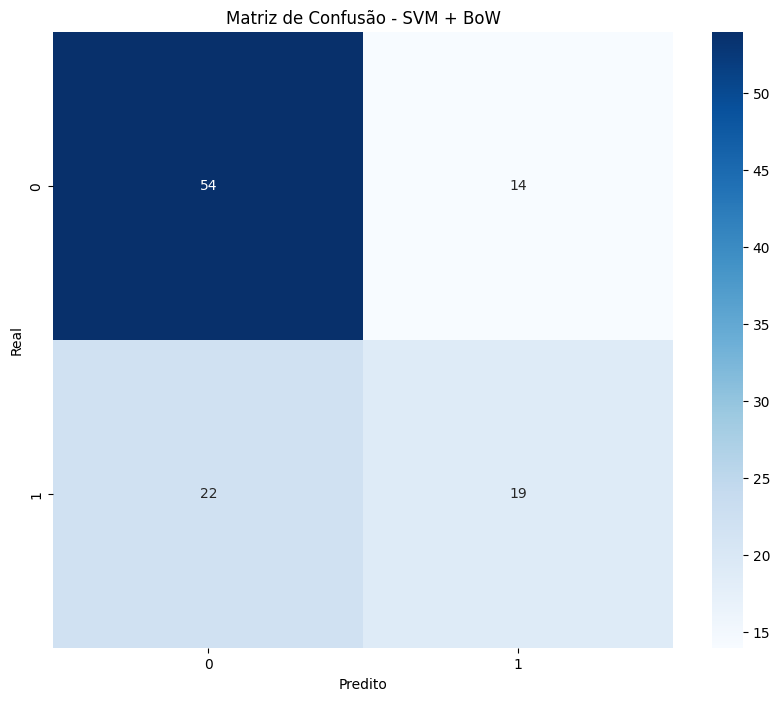


💾 Gráfico salvo: confusion_matrix_svm_bow.png


In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - SVM + BoW')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.savefig('confusion_matrix_svm_bow.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n💾 Gráfico salvo: confusion_matrix_svm_bow.png")

#**TESTANDO COM NOVAS REVIEWS**

In [ ]:
novas_reviews = [
    "This movie was absolutely amazing! I loved every moment of it.",
    "Terrible film. Waste of time and money. Do not watch.",
    "It was okay, nothing special but not bad either."
]

novas_reviews_bow = vectorizer.transform(novas_reviews)
predicoes = svm_model.predict(novas_reviews_bow)

for review, pred in zip(novas_reviews, predicoes):
    print(f"\nReview: {review[:50]}...")
    print(f"Nota predita: {pred}")


Review: This movie was absolutely amazing! I loved every m...
Nota predita: 0

Review: Terrible film. Waste of time and money. Do not wat...
Nota predita: 0

Review: It was okay, nothing special but not bad either....
Nota predita: 0
